In [11]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt

import pandas as pd
import random
import numpy as np
import sys

sys.path.append('../')
import decode_mcd.multi_objective_problem as MOP
from decode_mcd import data_package
from decode_mcd import design_targets
import load_data
import importlib

from IPython.display import display, HTML

In [2]:
def plot(ax, rangearr, xx, yy, Z, x, y, x2,y2, title, boundary=0.0, plottype = "generated", validity_status=0, color = "red", target=None, marker=None):
    
    font = {'weight' : 'bold',
        'size'   : 25}
    plt.rc('font', **font)
    
    black="#000000"
    
    if color == "blue":
        color = "#6C8EBF"
    elif color == "green":
        color = "#82B366"
    elif color == "orange":
        color = "#F2AF00"
    elif color == "yellow":
        color = "#D6B656"
    elif color == "purple": 
        color = "#9673A6"
    elif color == "red": 
        color = "#B85450"
    elif color == "gray": 
        color = "#888888"
    maincolor = color
        
    white = "#FFFFFF"
#     vgencol = orange
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [white, maincolor], N=7)
    objcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [white , maincolor], N=6)
    
    s=100
    ax.set_title(title)
    if validity_status==1: #Invalid Samples
        if plottype == "dataset":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=[maincolor], alpha=0.5)
        elif plottype == "invalid":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=[black], alpha=0.2)
        elif plottype == "generated":
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.1)
            ax.scatter(x,y, s=s, c=[maincolor])
            ax.scatter(x2,y2, s=s, c=[black])
        elif plottype == "objective":
            img = ax.imshow(Z.T, cmap=objcmap, alpha=0.7, origin='lower', extent = [-2,2,-2,2])    
            plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
            ax.scatter(x,y, s=s, c=black, alpha = 0.3)
            if target:
                CS = ax.contour(Z.T, [target], colors=black, vmin=0, vmax=2, extent = [-2,2,-2,2])
                ax.clabel(CS, fontsize=30, inline=True)
#                 manual_locations = [(-2, 2), (2,-2)]
#                 ax.clabel(CS, fontsize=30, inline=True, manual=manual_locations)
    else:
        if plottype=="objective":
            img = ax.imshow(Z.T, cmap=objcmap, alpha=0.5, origin='lower', extent = [-2,2,-2,2])
            plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
            ax.scatter(x,y, s=s, c="k", alpha = 0.3)
            if target:
                CS = ax.contour(Z.T, [target], colors='k', vmin=0, vmax=2, extent = [-2,2,-2,2])
#                 ax.clabel(CS, fontsize=30, inline=True)
                manual_locations = [(0, 2)]
                ax.clabel(CS, fontsize=30, inline=True, manual=manual_locations)
        elif plottype=="CF":
#             ax.scatter(x[1:],y[1:], s=s, c=color, alpha = 1, marker=marker)
            for i in range(np.shape(x2)[0]):
                idx1 = x2[i,0]
                idx2 = x2[i,1]
                ax.arrow(x[idx1], y[idx1], x[idx2]-x[idx1], y[idx2]-y[idx1], width = 0.01, head_width = 0.1, head_length = 0.1, length_includes_head=True, color = color, alpha=0.7)
#                 ax.plot([x[idx1], x[idx2]], [y[idx1], y[idx2]],c = color, alpha=0.7, linewidth=2)
            ax.scatter(x[0],y[0], s=5*s, c=color, alpha = 1, marker=marker)
            ax.annotate(y2, (x[0]-.15,y[0]+.15))
        elif plottype=="dataset": #No invalid Samples
            ax.scatter(x,y, s=s, c=black, alpha=0.15)
            ax.set_title("Original Data")
        elif plottype=="generated":
            ax.scatter(x2,y2, s=s, c=black, alpha=0.05)
            ax.scatter(x,y, s=s, c=maincolor, alpha=0.7)
        elif plottype=="conditional":
            ax.scatter(x2,y2, s=s, c=black, alpha=0.1)
            ax.scatter(x,y, s=s, c=maincolor, alpha=0.7)
        
    xlen = rangearr[0,1]-rangearr[0,0]
    ylen = rangearr[1,1]-rangearr[1,0]
    ax.set_xlim(rangearr[0,0]-xlen*boundary, rangearr[0,1]+xlen*boundary)
    ax.set_ylim(rangearr[1,0]-ylen*boundary, rangearr[1,1]+ylen*boundary)
    ax.axis('off')
    
    
def plotcfs(objectives, all_cfs, queries, flag="CF"):

    n_obj = len(objectives)
    rows = 1
    fig, ax = plt.subplots(rows, n_obj, figsize=(10*n_obj-0.2, 10*rows-1))

    backcolors = ["gray", "gray"]
    pointcolors = ["red", "yellow", "blue"]
#     markers = ["v", "^", "X"]
    markers = ["X", "X", "X"]
    ann = ["D1", "D2", "D3"]
    
    if flag == "data":
        for i in range(n_obj):
            xx_o, yy_o, Z_o = load_data.gen_background_plot(objectives[i], rangearr)
            plot(fig.axes[i], rangearr, xx_o, yy_o, Z_o, [], [], None, None, "", 
                 plottype = "objective", validity_status=False, color=backcolors[i], target=targets[i])
    elif flag == "reg":
        for i in range(n_obj):
            xx_r, yy_r = np.mgrid[rangearr[0,0]:rangearr[0,1]:.01, rangearr[1,0]:rangearr[1,1]:.01]
            grid = np.c_[xx_r.ravel(), yy_r.ravel()]
            Z_r = regressor.predict(grid)[:,i]
            Z_r = Z_r.reshape(xx_r.shape)

            plot(fig.axes[i], rangearr, xx_r, yy_r, Z_r, [], [], None, None, "", 
                 plottype = "objective", validity_status=False, color=backcolors[i], target=targets[i])
        
    else:
        for i in range(n_obj):
            xx_o, yy_o, Z_o = load_data.gen_background_plot(objectives[i], rangearr)
            plot(fig.axes[i], rangearr, xx_o, yy_o, Z_o, [], [], None, None, "", 
                 plottype = "objective", validity_status=False, color=backcolors[i], target=targets[i])


            for j in range(len(all_cfs)):
                cfs = all_cfs[j]
                query = queries[j]
                connections=np.zeros((num_samples+1, 2), dtype=int)
                for k in range(num_samples):
                    connections[k, :] = (0, 1+k)

                points_to_plot = cfs.copy()
                points_to_plot = pd.concat([query, points_to_plot], axis=0)
                points_to_plot = points_to_plot.values

                xx_o, yy_o, Z_o = load_data.gen_background_plot(objectives[i], rangearr)
                plot(fig.axes[i], rangearr, xx_o, yy_o, Z_o, points_to_plot[:,0], points_to_plot[:,1], connections, ann[j], "", 
                     plottype = "CF", validity_status=False, color=pointcolors[j], target=targets[i], marker = markers[j])
    plt.show()

In [3]:
functions=[]
DM_val = load_data.all_val_wrapper()
sampling_func = load_data.sample_uniform_wrapper(10000,0) #Uniform Sampling with Number of positive samples & Negative Samples
rangearr = np.array([[-2,2], [-2,2]])
objectives=[load_data.exp_obj_wrapper(0.8,0.8), load_data.circle_obj_wrapper(0)]
targets = [0.5, 0.6]
x_scaled, _, _, scaler = load_data.gen_toy_dataset(sampling_func, DM_val, None, rangearr, False, True)

In [4]:
x = scaler.inverse_transform(x_scaled)
y = load_data.eval_obj(x, objectives)


In [5]:
x_df = pd.DataFrame(x, columns = ["X", "Y"])
y_df = pd.DataFrame(y, columns = ["O1", "O2"])



In [6]:
print(x_df)

             X         Y
0     1.092617 -1.831915
1     1.122176 -0.806908
2    -0.398444  0.546641
3    -1.673024 -0.873726
4     0.875033 -0.611524
...        ...       ...
9995  1.723854 -0.723421
9996 -0.565233 -0.715874
9997  0.147649 -1.086203
9998  0.036271  1.792888
9999 -0.990729 -0.172598

[10000 rows x 2 columns]


In [24]:
def fn_wrapper(x):
    y = load_data.eval_obj(x.values, objectives)
    return y

In [25]:
def fn(x):
    return load_data.eval_obj(x, objectives)

In [46]:
from decode_mcd_private import calculate_dtai
from decode_mcd.counterfactuals_generator import CounterfactualsGenerator
from pymoo.core.variable import Real, Integer, Binary, Choice
import decode_mcd.multi_objective_problem as MOP

T1 = design_targets.ContinuousTarget("O1", 0.4, 0.6)
T2 = design_targets.ContinuousTarget("O2", 0.6, np.inf)
dt = design_targets.DesignTargets((T1, T2), None, None)

bonus_objs = ["O1", "O2"]
# query_x = x_df.sample(1, axis=0)
datatypes = [Real(bounds=(-1, 1)), Real(bounds=(-1, 1))]


cfsets = []
queries = []
queries.append(pd.DataFrame([[0.512015,  0.574678]], columns = x_df.columns))
# queries.append(pd.DataFrame([[-0.5, -0.2]], columns = x_df.columns))
# queries.append(pd.DataFrame([[1.75, 0.4]], columns = x_df.columns))
for i in range(len(queries)):
    query_x = queries[i]
    
    dp = data_package.DataPackage(x_df, y_df, query_x, dt, datatypes, ["X", "Y"], bonus_objs)
    problem = MOP.MultiObjectiveProblem(dp, fn_wrapper, [])
    gen = CounterfactualsGenerator(problem, 500, initialize_from_dataset=True)
    gen.generate(5)
    cfsets.append(gen)

2479 dataset entries found matching problem parameters
Initial population initialized from dataset of 2479 samples!
Training GA from 0 to 5 generations!
     1 |        0 |     18 |  0.000000E+00 |  1.4157258065 |  0.0440214812 |         ideal
     2 |      500 |     27 |  0.000000E+00 |  0.9040000000 |  0.4075794665 |         nadir
     3 |     1000 |     34 |  0.000000E+00 |  0.8720000000 |  0.0196350215 |         nadir
     4 |     1500 |     38 |  0.000000E+00 |  0.8220000000 |  0.0079578412 |         ideal
     5 |     2000 |     46 |  0.000000E+00 |  0.7560000000 |  0.0042741420 |         ideal


In [47]:
num_samples = 10
all_cfs=[]
for i in range(len(cfsets)):
    cfs = cfsets[i].sample_with_dtai(num_samples, 0.5, 0.2, 0.5, 0.2, np.array([1,1]), include_dataset=False, num_dpp=10000)
    all_cfs.append(cfs)
plotcfs(objectives, all_cfs, queries)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
          X         Y
0  0.512015  0.574678
          X         Y
0  0.512015  0.574678
1 -0.505636  0.574678
2  0.578147  0.574678
3  0.512015 -0.628854
4  0.512015  0.612341
5  0.530850  0.574678
6  0.512015  0.629029
7  0.512015  0.578507
8  0.512015  0.586711
9  0.512015  0.566623
       X      Y
0   True   True
1  False   True
2  False   True
3   True  False
4   True  False
5  False   True
6   True  False
7   True  False
8   True  False
9   True  False


AttributeError: 'NoneType' object has no attribute 'all'

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


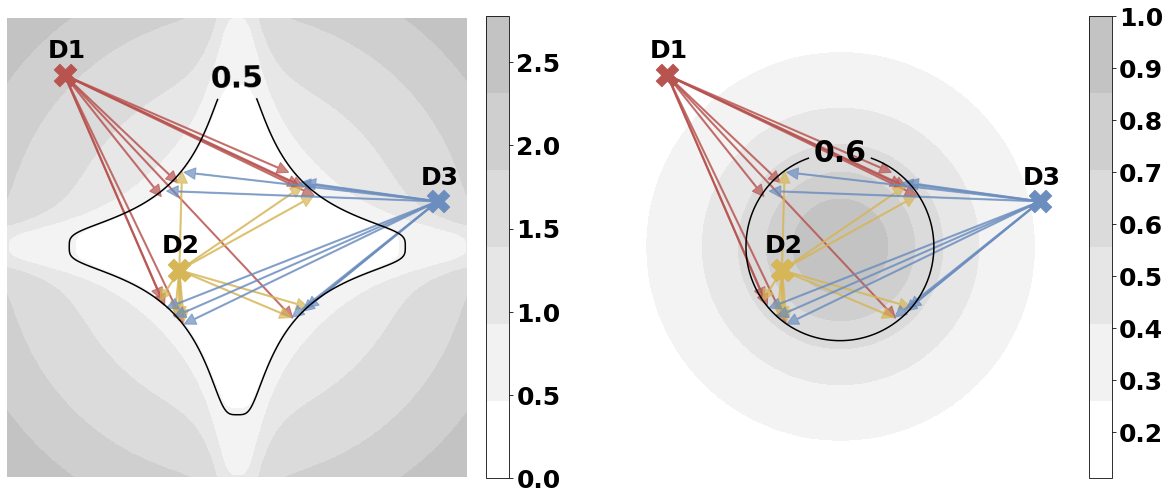

In [13]:
num_samples = 10
all_cfs=[]
for i in range(len(cfsets)):
    cfs = cfsets[i].sample_with_dtai(num_samples, 0.5, 0.2, 0.5, 20, np.array([1,1]), include_dataset=True, num_dpp=10000)
    all_cfs.append(cfs)
plotcfs(objectives, all_cfs, queries)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


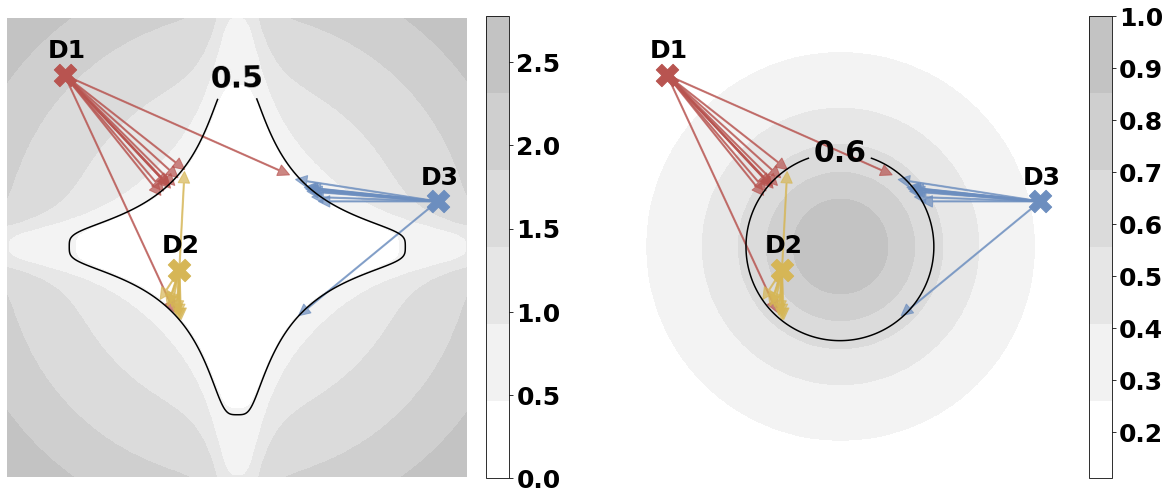

In [14]:
from pymoo.core.population import Population
num_samples = 10
all_cfs=[]
for i in range(len(cfsets)):
    cfs = cfsets[i].sample_with_dtai(num_samples, 0.5, 0.2, 50, 0.2, np.array([1,1]), include_dataset=True, num_dpp=10000)
    all_cfs.append(cfs)
plotcfs(objectives, all_cfs, queries)

Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Calculating diversity matrix!
Sampling diverse set of counterfactual candidates!
Done! Returning CFs


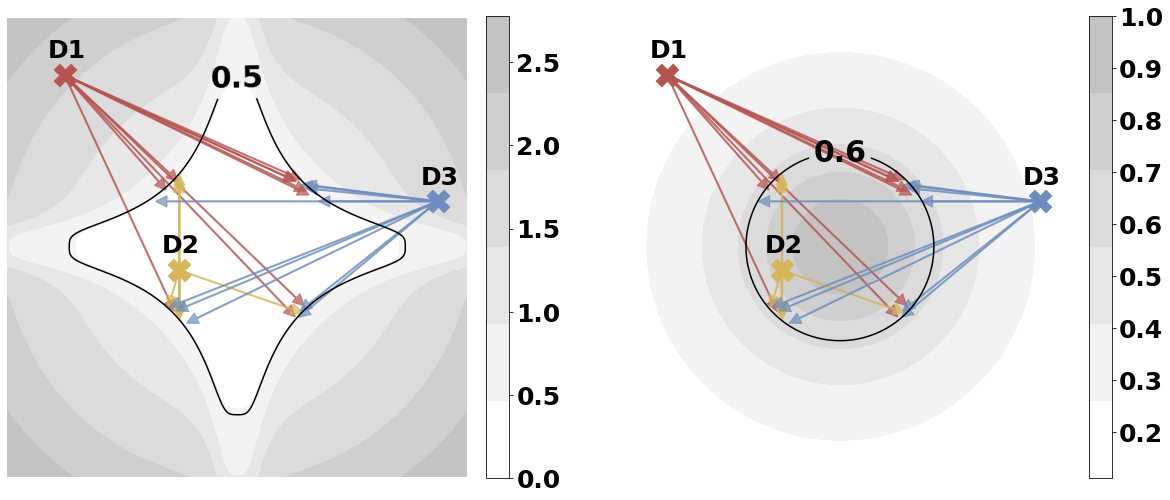

In [15]:
from pymoo.core.population import Population
num_samples = 10
all_cfs=[]
for i in range(len(cfsets)):
    cfset = cfsets[i]
    cfs = cfsets[i].sample_with_dtai(num_samples, 0.5, 20, 0.5, 0.2, np.array([1,1]), include_dataset=True, num_dpp=50000)
    all_cfs.append(cfs)
plotcfs(objectives, all_cfs, queries)